In [1]:
import anndata as ad
import scanpy as sc
import numpy as np
import seaborn as sns
import palettable
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
import pickle
import sys
import scipy
sys.path.append('/home/yzy/bioSIMS/code/analysis')
# from utils_220 import *
# sc.set_figure_params(dpi=500, color_map='viridis')
sc.set_figure_params(dpi=500, color_map='viridis',dpi_save=500,transparent=True)

sc.settings.verbosity = 2
heatmap_cmp = palettable.cmocean.diverging.Balance_20.mpl_colormap

# %matplotlib inline


/home/yzy/anaconda3/envs/pytorch/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
import inspect
inspect.signature(np.argsort)


<Signature (a, axis=-1, kind='quicksort', order=None)>

# load count data

In [4]:
filename = '../../data/RNAseq/ntd.csv'
a = sc.read_csv(filename,dtype='str')

# adata = sc.read_csv(filename,delimiter=' ').transpose()

In [5]:
a.obs['label'] = np.array(a[:,'ntd$Region'].X)

In [6]:
var_name_list = a.var_names[:-1]

In [7]:
a_clean = a[:,var_name_list]

In [25]:
a_clean.X[:] = np.array(a_clean.X,dtype='float')

Trying to set attribute `.X` of view, copying.


In [27]:
topk=500
a_clean.var['var'] = np.var(a_clean.X,axis=0)
var_argsort = np.flip(np.argsort(a_clean.var['var']))
var_name_argsort = a_clean.var_names[var_argsort]
a_clean = a_clean[:,var_name_argsort[0:topk]]

In [28]:
def cal_dist_mat(cur_pca,cur_label,method='mean'):
#     method = 'mean'
    cls_unique = np.unique(cur_label)
    n_cls = cls_unique.shape[0]
    cls_dist_mat = np.zeros(shape=(n_cls,n_cls))
    ii = 0
    jj = 0
    for i in cls_unique:
        jj=0
        for j in cls_unique:
            pca_mat_i = cur_pca[cur_label==i,:]
            pca_mat_j = cur_pca[cur_label==j,:]
            cur_dist_mat = scipy.spatial.distance_matrix(pca_mat_i,pca_mat_j)
            if method=='max':
                cur_dist = np.max(cur_dist_mat)
            elif method=='min':
                cur_dist = np.min(cur_dist_mat)
            elif method=='mean':
                cur_dist = np.mean(cur_dist_mat)
            elif method=='centroid':
                cur_c_i = np.mean(pca_mat_i,axis=0)
                cur_c_j = np.mean(pca_mat_j,axis=0)
                cur_dist = np.sqrt(np.sum(np.square(cur_c_i-cur_c_j)))
            cls_dist_mat[ii,jj] = cur_dist
            jj+=1
        ii+=1
    return cls_dist_mat

In [29]:
# import sklearn.decomposition.PCA as pca
from sklearn.decomposition import PCA 

npc_list = range(2,16)
n2f_list = []
d2f_list = []
for npc in npc_list:
    pca = PCA(n_components=npc)
    cur_pca = pca.fit_transform(a_clean.X)
    
#     sc.tl.pca(a_clean,n_comps=npc)
#     cur_pca = a_clean.obsm['X_pca']
    cur_label = a_clean.obs['label']
    cls_dist_mat = cal_dist_mat(cur_pca,cur_label,method='centroid')
    cur_n2f = cls_dist_mat[2,1]
    cur_d2f = cls_dist_mat[0,1]
    n2f_list.append(cur_n2f)
    d2f_list.append(cur_d2f)
n2f_list = np.array(n2f_list)
d2f_list = np.array(d2f_list)
clsdist_ratio_list = d2f_list/n2f_list
pca_variance_list = pca.explained_variance_ratio_
accu_pca_variance = np.zeros_like(pca_variance_list)
tmp = 0
for i in range(pca_variance_list.shape[0]):
    tmp +=pca_variance_list[i]
    accu_pca_variance[i] = tmp
accu_pca_variance = accu_pca_variance[1:]

# plot PCA distance at all number of PCs.

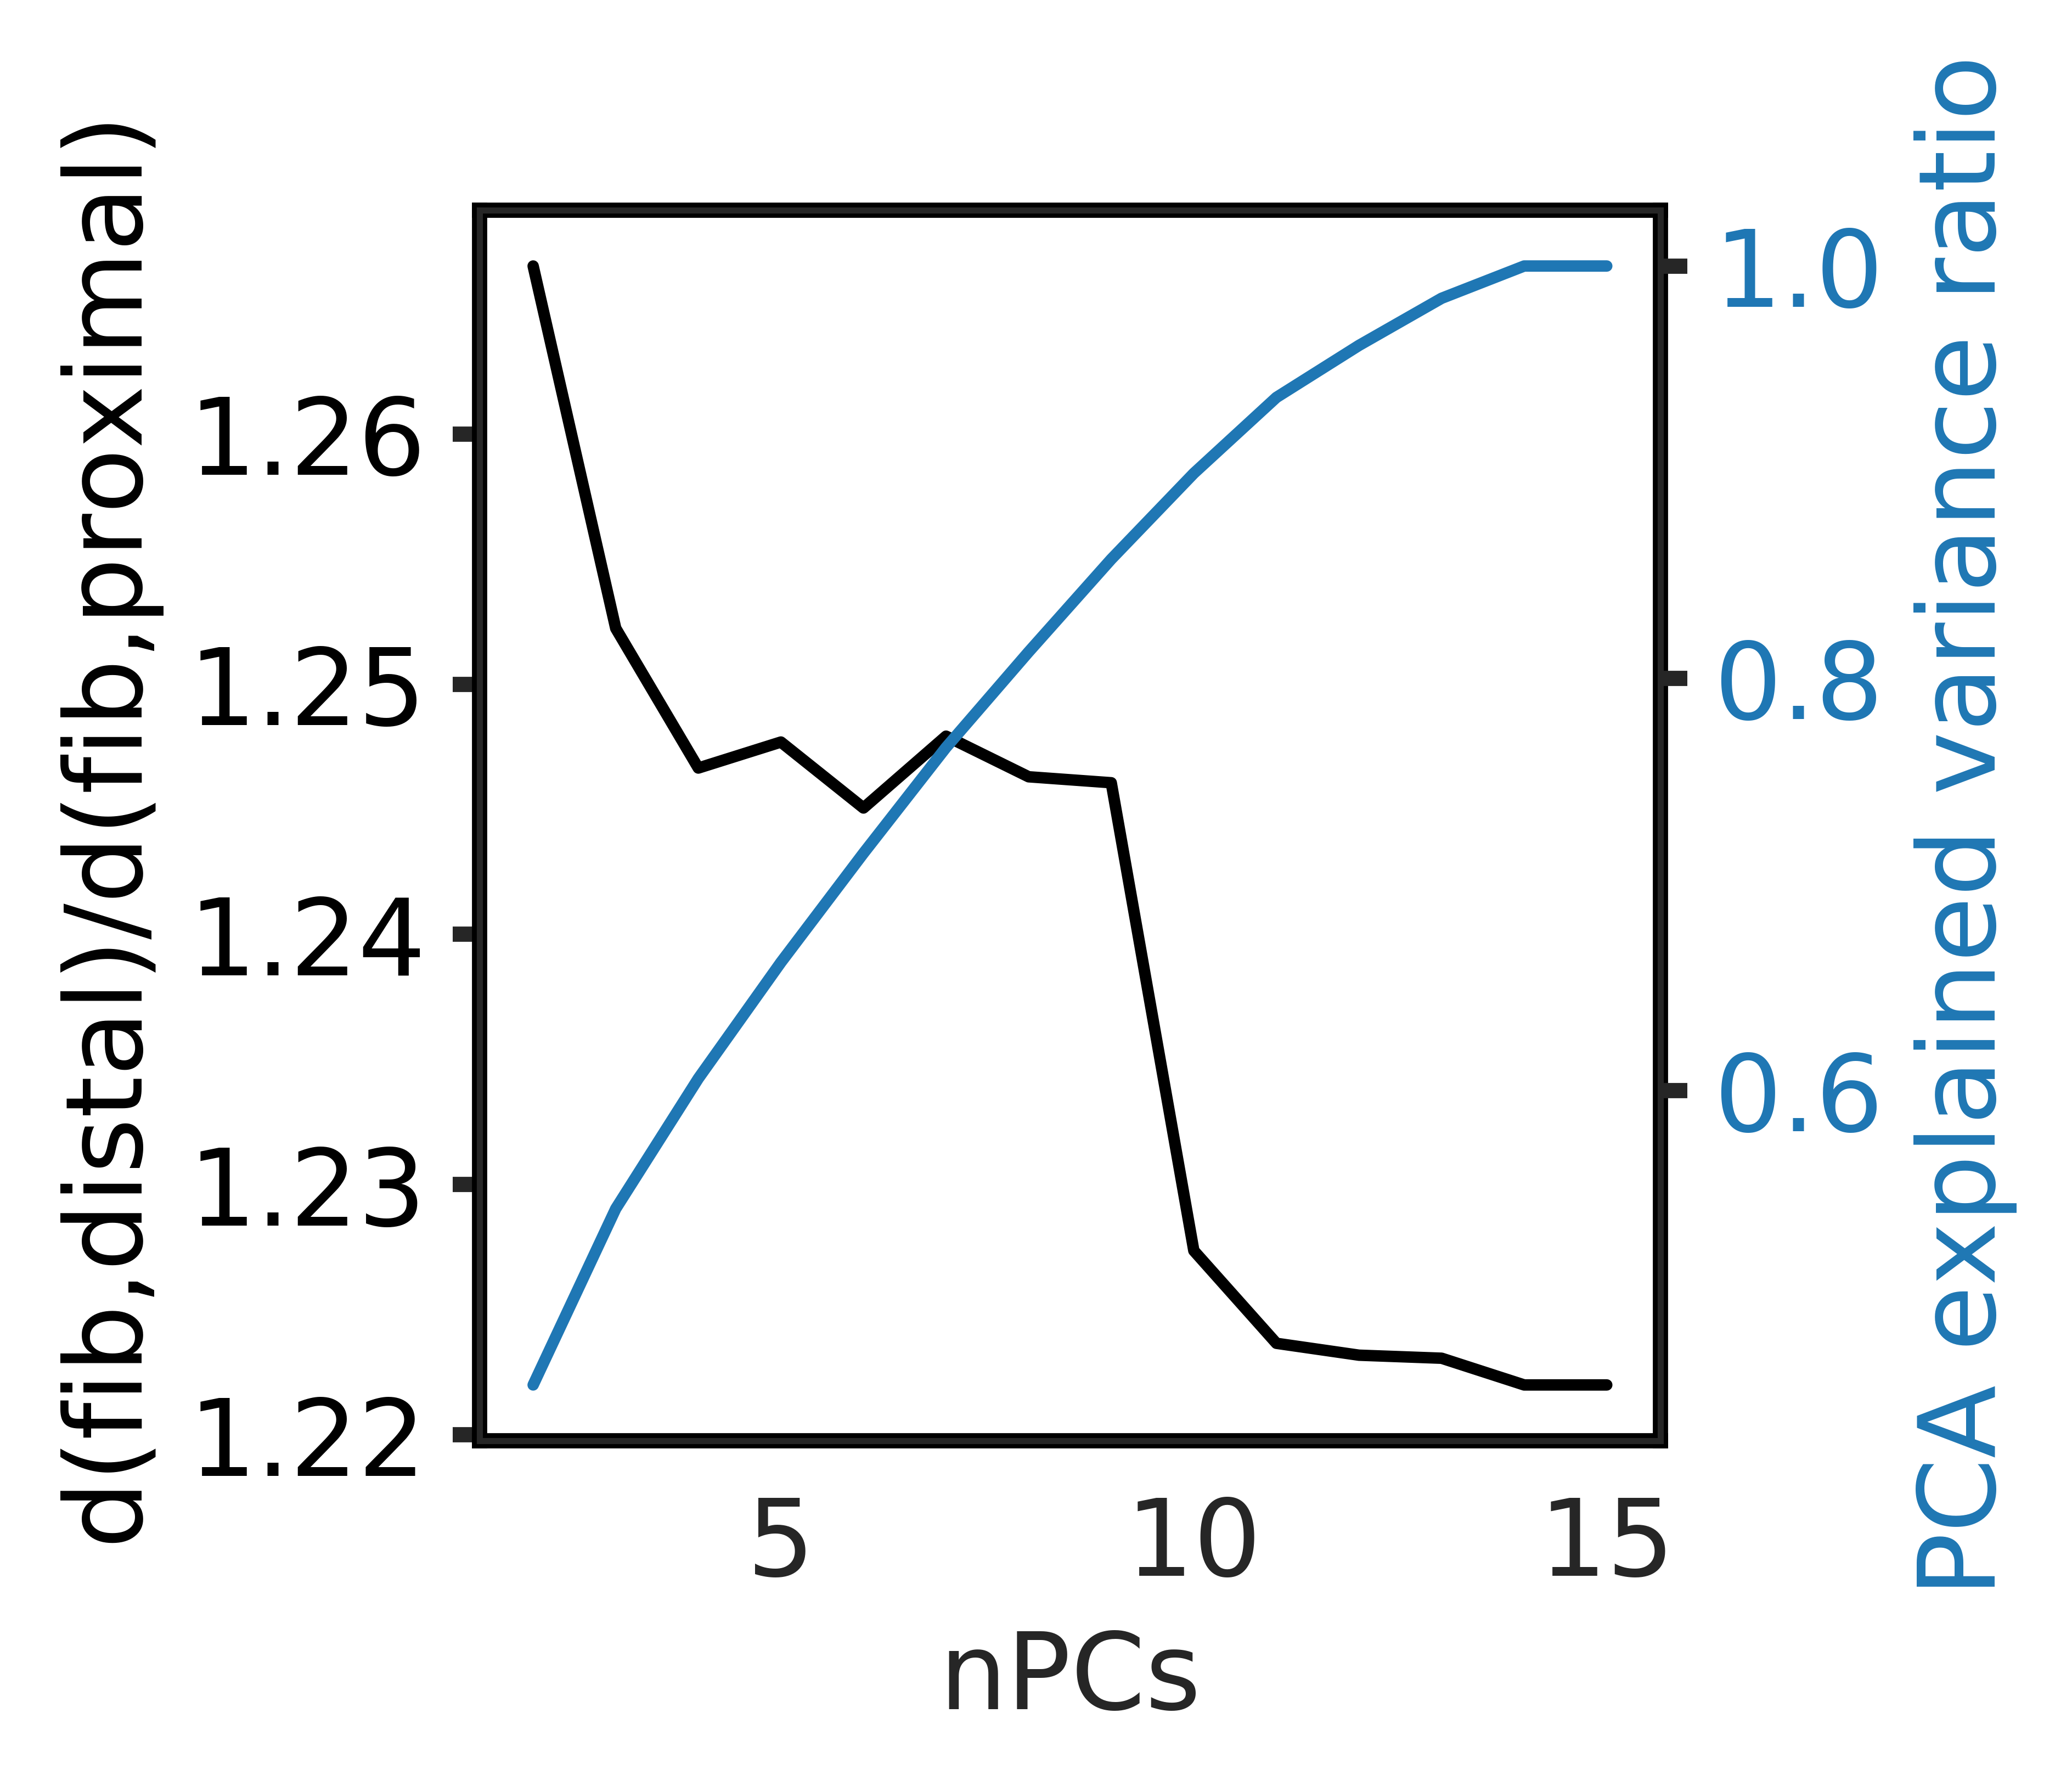

In [30]:
# def plot_count_ratio(count_ratio_standard_list,thre_list,save):
sns.set_style('white')
#     save_tmp = 'figures/fibro_dist_line_{0}.png'

t=npc_list
data1 = clsdist_ratio_list
data2 = accu_pca_variance
fig, ax1 = plt.subplots(1,1,figsize=(6/1.5,5/1.5))

color = 'k'
ax1.set_xlabel('nPCs')
ax1.set_ylabel('d(fib,distal)/d(fib,proximal)', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('PCA explained variance ratio', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax1.spines["bottom"].set_color("black")
ax1.spines["left"].set_color("black")

ax1.spines["top"].set_color("black")
ax1.spines['right'].set_color("black")
# ax.spines["left"].set_facecolor("red")
ax1.spines["left"].set_linewidth(2)
ax1.spines["bottom"].set_linewidth(2)
ax1.spines["right"].set_linewidth(2)
ax1.spines["top"].set_linewidth(2)

ax1.xaxis.set_tick_params(width=2)
ax1.yaxis.set_tick_params(width=2)
ax2.xaxis.set_tick_params(width=2)
ax2.yaxis.set_tick_params(width=2)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.show()
# if save:

#     plt.savefig(save,transparent=True,format='png',bbox_inches='tight',dpi=500)
# plt.savefig(transparent=True,format='png',bbox_inches='tight',dpi=500)


In [32]:
cls_cmp = ['#68FF00','#006FFF','#FF005C']
a_clean.uns['label_colors'] = cls_cmp

# 2D PCA ploting

In [33]:
sc.tl.pca(a_clean)
fig,ax = plt.subplots(1,1,figsize=(10,10))
sc.pl.pca(a_clean,color='label',s=5000,projection='2d',ax=ax)

computing PCA with n_comps = 14
    finished (0:00:00)


# 3D PCA ploting

In [ ]:
# %matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
# fig,ax = plt.subplots(1,1,figsize=(5,5),projection='3d')
c_list = []
for l in a_clean.obs['label']:
    if l=='"Distant"':
        c_list.append(cls_cmp[0])
    elif l=='"Fibrosis"':
        c_list.append(cls_cmp[1])
    else:
        c_list.append(cls_cmp[2])
        
ax.scatter(a_clean.obsm['X_pca'][:,0],a_clean.obsm['X_pca'][:,1],
           a_clean.obsm['X_pca'][:,2],c=c_list,s=80)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

In [ ]:
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
# fig,ax = plt.subplots(1,1,figsize=(5,5),projection='3d')
c_list = []
for l in a_clean.obs['label']:
    if l=='"Distant"':
        c_list.append(cls_cmp[0])
    elif l=='"Fibrosis"':
        c_list.append(cls_cmp[1])
    else:
        c_list.append(cls_cmp[2])
        
ax.scatter(a_clean.obsm['X_pca'][:,0],a_clean.obsm['X_pca'][:,1],
           a_clean.obsm['X_pca'][:,2],c=c_list,s=80)